In [10]:
import pandas as pd
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric, STOPWORDS
import nltk
nltk.download("wordnet")

from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases

import crear_modelo_config

if __name__ == "__main__":
    ml_dataset = pd.read_csv("TweetsTrainDev.csv")
    ml_dataset.drop(ml_dataset[ml_dataset["airline"] != "United"].index, inplace = True)
    ml_dataset.drop(ml_dataset[ml_dataset["airline_sentiment"] != "negative"].index, inplace = True)

    docs = list(ml_dataset["text"])
    original_docs = docs[:]
    # Split the documents into tokens.
    tokenizer = RegexpTokenizer(r'\w+')

    stopwords = STOPWORDS.union(frozenset(["ua", "we", "on", "me", "you"])).difference(["kg", "before", "over", "system", "serious", "off", "take", "nowhere", "found"])
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = remove_stopwords(docs[idx], STOPWORDS)
        docs[idx] = strip_punctuation(docs[idx])
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words."""

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 1] for doc in docs]

    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=20)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    
    # Create a dictionary representation of the documents.
    dictionary = Dictionary(docs)

    # Filter out words that occur less than 20 documents, or more than 50% of the documents.
    dictionary.filter_extremes(no_below=10, no_above=0.2)

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))

    # Set training parameters.
    num_topics = 12
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    # Make an index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    models = []
    for alpha in range(1, 100, 10):
        alpha = alpha / 10_000_000.0
        # 0.00001 -> 0.001, step=0.0001
        model = LdaModel(
            corpus=corpus,
            id2word=id2word,
            chunksize=chunksize,
            alpha=alpha,
            eta='auto',
            iterations=iterations,
            num_topics=num_topics,
            passes=passes,
            eval_every=eval_every # type: ignore
        )
        models.append(model)

    #diccionario = Dictionary(ml_dataset.Tokens)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Number of unique tokens: 481
Number of documents: 2633


In [11]:
coherences = []
alpha_arr = []

alpha = 0.00001
for model in models:
        top_topics = model.top_topics(texts=docs, dictionary=dictionary, coherence="c_v")
        # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
        avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
        #print('Average topic coherence: %.4f.' % avg_topic_coherence)

        coherences.append(avg_topic_coherence)
        alpha_arr.append(alpha)
        print(f"alpha: {alpha}, avg_coherence: {avg_topic_coherence}")
        alpha += 0.0001

alpha: 1e-05, avg_coherence: 0.31216921830470096
alpha: 0.00011, avg_coherence: 0.32078628000589066
alpha: 0.00021, avg_coherence: 0.3184081883252138
alpha: 0.00031, avg_coherence: 0.32238452043088767
alpha: 0.00041, avg_coherence: 0.3220940454025792
alpha: 0.00051, avg_coherence: 0.3051207967223407
alpha: 0.0006100000000000001, avg_coherence: 0.32378067670380656
alpha: 0.0007100000000000001, avg_coherence: 0.33819682543115087
alpha: 0.0008100000000000002, avg_coherence: 0.30964983076564484
alpha: 0.0009100000000000002, avg_coherence: 0.3231479186610516


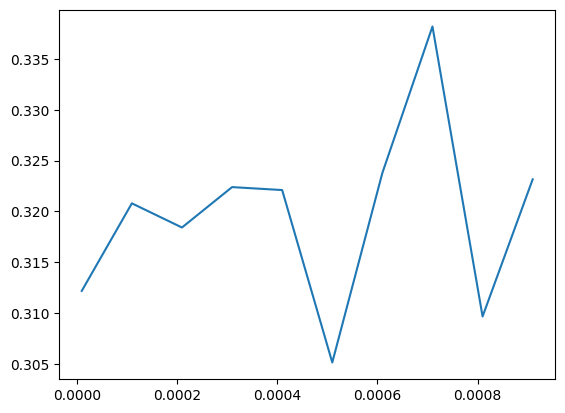

In [12]:

import matplotlib.pyplot as plt
import numpy as np

valores = np.array(coherences)
etiquetas = np.array(alpha_arr)

plt.plot(etiquetas, valores)
plt.show()
